In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb
import shap


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)  

In [2]:
feature = pd.read_csv('multiasset_feature.csv')
# idx = pd.read_csv('multiasset_index.csv')
# idx.columns = ['Date', 'idx_price']
# idx['Date'] = idx.index
# feature.shape, idx.shape

## create lagging features 1~5 months

In [3]:
idx = pd.read_csv('multiasset_index.csv', index_col='Date')
idx.columns = ['idx_price']

In [4]:
lag_length = 16

for i in range(1, lag_length):
    idx['lag_'+ str(i)] = idx['idx_price'].shift(i)
    
idx.head(10)

,idx_price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
Date,,,,,,,,,,,,,,,,
1/31/2000,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/2000,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/31/2000,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4/30/2000,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/31/2000,185.5,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6/30/2000,179.2,185.5,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7/31/2000,183.2,179.2,185.5,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8/31/2000,172.3,183.2,179.2,185.5,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/30/2000,168.1,172.3,183.2,179.2,185.5,180.4,188.2,197.7,186.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dt = feature.merge(idx, how='left', on='Date')
dt.shape

(252, 76)

In [7]:
ft = pd.DataFrame(dt.columns.to_list())
ft.to_csv('features.csv', index=False)

In [218]:
dt['Fed Balance Sheet'] = dt['Fed Balance Sheet'].apply(lambda x: x.replace(",", ""))
dt['Fed Balance Sheet'] = dt['Fed Balance Sheet'].apply(lambda x: x.replace(" ", ""))
dt['Fed Balance Sheet'] = dt['Fed Balance Sheet'].apply(lambda x: int(float(x)))

dt['US Real Personal Income'] = dt['US Real Personal Income'].apply(lambda x: x.replace(",", ""))
dt['US Real Personal Income'] = dt['US Real Personal Income'].apply(lambda x: x.replace(" ", ""))
dt['US Real Personal Income'] = dt['US Real Personal Income'].apply(lambda x: int(float(x)))

dt['US Real Personal Income exTrans'] = dt['US Real Personal Income exTrans'].apply(lambda x: x.replace(",", ""))
dt['US Real Personal Income exTrans'] = dt['US Real Personal Income exTrans'].apply(lambda x: x.replace(" ", ""))
dt['US Real Personal Income exTrans'] = dt['US Real Personal Income exTrans'].apply(lambda x: int(float(x)))

dt['Adv Retail Sales US exFood Services'] = dt['Adv Retail Sales US exFood Services'].apply(lambda x: x.replace(",", ""))
dt['Adv Retail Sales US exFood Services'] = dt['Adv Retail Sales US exFood Services'].apply(lambda x: x.replace(" ", ""))
dt['Adv Retail Sales US exFood Services'] = dt['Adv Retail Sales US exFood Services'].apply(lambda x: int(float(x)))

In [219]:
dt['pred_price'] = dt['idx_price'].shift(-1)
# truncate dataset
dt = dt.iloc[(lag_length-1):, ]
dt

,Date,Cycle Indicator Global,Eurozone Retail Sales,Eurozone Industrial Production exconstr,Eurozone Industrial Production manuf,US Privately Owned Housing Starts,US HomeBuilders Market Index,US Real Personal Income,US Real Personal Income exTrans,US Indus Prod Index,Adv Retail Sales US exFood Services,US JoblessClaims Seasonally Adjusted,US U6 Unemp Rate,World EPS forecast 3M Change,US M1 Growth YOY,RealUS M1 Growth YOY,FED Excess Reserves,Fed Balance Sheet,ECB Balance Sheet,Real Yield US,US 10yr Rate,Germany 10yr Rate,EU 10Y 2Y Curve,US 10Y 2Y Curve,Fed Fwd 6 Month,Fed Fwd 12 Month,Chinese Oil Imports,Japanese Export China,Industrial Metal Prices,US Core CPI,Inflation Surprise Global,US Breakeven Inflation,US PCE YOY,US Financial Conditions Index A,US Financial Conditions Index B,EU Financial Conditions Index A,EU Financial Conditions Index B,US IG Spreads,US HY Spreads,EU IG Spreads,EU HY Spreads,US Credit Standards,Global Equity 3 Month Momentum,Global Equity 6 Month Momentum,Global Equity 12 Month Momentum,Vix Index,Commercial Paper Spread,V2x Index,Eonia Spread,Equity Risk Premia,Sentiment Macro Fundamentals Global News Social,Sentiment Consumer Sentiment Global News Social,Sentiment Economic Growth Global News Social,Sentiment Trade Balance Global News Social,Sentiment environmental composite GLOBAL News,Sentiment social composite GLOBAL News,Sentiment governance composite GLOBAL News,Sentiment governance composite GLOBAL News Social,Sentiment social composite GLOBAL News Social,Sentiment environmental composite GLOBAL News Social,idx_price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,pred_price
15,4/30/2001,-0.2,93.4,96.8,95.5,-4.3,58.6,9689,8430,92.1,259997,363.0,7.2,-3.1,-0.6,0.0,13.8,602572,832.6,3.5,5.2,4.9,39.3,44.0,5.0,5.2,0.2,0.4,118.2,2.6,12.5,1.7,1.9,99.8,-1.0,98.5,-0.2,280.0,7.0,0.7,10.1,31.2,-0.1,-0.1,-0.1,26.1,39.9,25.1,4.8,1.9,-0.4,-0.2,-0.6,-0.4,-0.3,-0.9,0.1,0.0,-0.8,-0.4,143.9,146.4,136.2,146.8,161.0,157.6,156.8,168.1,172.3,183.2,179.2,185.5,180.4,188.2,197.7,186.5,139.0
16,5/31/2001,-0.3,93.6,96.8,95.5,-2.7,58.7,9690,8422,91.8,261323,371.8,7.3,-3.9,-0.1,0.0,14.0,606979,829.1,3.5,5.3,4.9,48.4,65.4,4.6,5.2,0.2,0.4,117.9,2.6,12.3,1.8,2.0,99.8,-0.9,98.5,-0.1,277.0,6.9,0.7,10.3,34.0,-0.1,-0.1,-0.2,25.2,36.8,23.9,4.8,1.9,-0.4,-0.1,-0.6,-0.4,-0.2,-0.8,0.1,0.2,-0.8,-0.3,139.0,143.9,146.4,136.2,146.8,161.0,157.6,156.8,168.1,172.3,183.2,179.2,185.5,180.4,188.2,197.7,136.4
17,6/30/2001,-0.3,93.7,96.6,95.0,-1.4,58.5,9688,8413,91.4,262255,381.6,7.5,-4.4,0.6,0.0,14.1,607927,830.8,3.4,5.3,5.0,55.9,80.9,4.3,5.2,0.2,0.3,116.1,2.6,12.0,1.9,2.0,99.9,-0.7,98.5,0.0,275.5,6.9,0.7,10.4,34.0,0.0,-0.1,-0.2,24.0,31.1,23.3,4.7,1.9,-0.3,0.2,-0.7,-0.4,0.1,-0.9,0.0,0.1,-0.8,-0.1,136.4,139.0,143.9,146.4,136.2,146.8,161.0,157.6,156.8,168.1,172.3,183.2,179.2,185.5,180.4,188.2,129.8
18,7/31/2001,-0.4,93.8,96.5,94.8,0.4,58.6,9689,8407,91.0,263324,385.8,7.6,-4.8,1.3,0.0,14.3,611651,836.3,3.4,5.2,5.0,62.2,92.6,4.1,5.2,0.2,0.3,113.1,2.6,9.9,1.8,2.0,100.0,-0.6,98.5,-0.1,275.9,7.0,0.7,10.7,34.0,0.0,-0.1,-0.2,23.5,23.7,23.8,4.7,1.9,-0.5,0.0,-0.8,-0.6,0.1,-0.9,-0.4,-0.1,-0.8,-0.1,129.8,136.4,139.0,143.9,146.4,136.2,146.8,161.0,157.6,156.8,168.1,172.3,183.2,179.2,185.5,180.4,117.6
19,8/31/2001,-0.4,93.9,96.4,94.7,4.3,58.2,9689,8405,90.6,263674,389.7,7.8,-5.3,2.2,0.0,14.5,616677,837.2,3.4,5.2,4.9,67.5,102.0,3.9,5.2,0.1,0.2,109.8,2.6,6.8,1.8,2.0,100.0,-0.5,98.6,-0.2,280.0,7.0,0.7,11.1,28.6,0.0,-0.1,-0.2,23.0,16.8,24.3,4.6,2.0,-0.7,-0.1,-0.9,-0.7,0.3,-0.8,-0.3,0.0,-0.8,0.0,117.6,129.8,136.4,139.0,143.9,146.4,136.2,146.8,161.0,157.6,156.8,168.1,172.3,183.2,179.2,185.5,119.8
20,9/30/2001,-0.5,94.0,95.8,94.1,3.6,58.4,9694,8404,90.2,264287,397.3,8.0,-5.8,4.3,0.0,20.1,628588,831.7,3.3,5.0,4.9,81.0,119.2,3.5,5.2,0.0,0.2,106.6,2.7,3.0,1.7,2.0,100.2,-0.8,98.8,-0.6,292.4,7.2,0.8,11.8,28.6,0.0,-0.1,-0.2,25.6,15.6,29.5,4.4,2.2,-0.9,-0.4,-0.9,-0.8,0.4,-0.7,-0.2,0.1,-0.7,0.2,119.8,117.6,129.8,136.4,139.0,143.9,

## split dataset

In [239]:
X = pd.DataFrame(dt.drop(['Date', 'idx_price', 'pred_price'], axis=1))
y = pd.DataFrame(dt['pred_price'])
X.shape, y.shape

((237, 74), (237, 1))

In [240]:
# forecast next month:
X_forecast = pd.DataFrame(X.iloc[-1, ]).T

X.drop(X.tail(1).index,inplace=True) 
y.drop(y.tail(1).index,inplace=True) 
X.shape, y.shape

((236, 74), (236, 1))

In [273]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.25, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
X_train.shape, X_test.shape, y_train.shape

((177, 74), (59, 74), (177, 1))

## train model

In [274]:
xgb_model = xgb.XGBRegressor(learning_rate=0.03)

In [275]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("MAE: %.2f" % (mae))

MSE: 191.20
RMSE: 13.83
MAE: 10.69


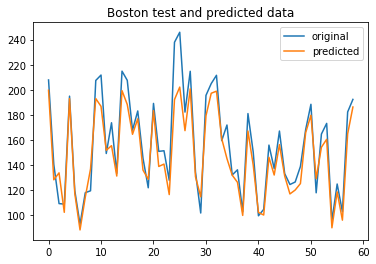

In [278]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

## forecast

In [283]:
y_forecast = xgb_model.predict(X_forecast)
y_forecast

array([202.20883], dtype=float32)

### DO NOT RUN Grid Search !!!

In [257]:
# grid search to find best parameters:
random_grid = {'colsample_bytree': [0.5, 0.7, 0.8],  # Specify the fraction of columns to be subsampled
               'gamma': [1, 2, 3],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
               'max_depth': [4, 5, 6],  # Maximum number of levels in tree
               'n_estimators': [25, 50, 100],  # Number of trees in forest
               'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
               'subsample': [0.7, 0.8, 0.9]  # Subsample ratio of the training instances
               }

xgbr = RandomizedSearchCV(estimator=xgb_model, param_distributions=random_grid, n_iter=100, cv=10, verbose=2,
                                        random_state=42, n_jobs=-1, scoring=make_scorer(mean_squared_error, squared=False))
xgbr.fit(X_train, y_train)
xgb_model = xgbr.best_estimator_
xgb_model

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.6s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=25, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

### DO NOT RUN Grid Search !!!

## feature importance - SHAP

In [279]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [280]:
# overall feature importance:
shap_sum = np.abs(shap_values).mean(axis=0)  # mean along the columns/features
overall = pd.DataFrame([X_train.columns, shap_sum.tolist()]).T
overall.columns = ['Feature', 'Score']
overall.sort_values('Score',ascending=False)

,Feature,Score
59,lag_1,17.4357
39,EU HY Spreads,2.76886
6,US Real Personal Income,1.9594
7,US Real Personal Income exTrans,1.27032
62,lag_4,0.968801
1,Eurozone Retail Sales,0.960804
60,lag_2,0.833683
9,Adv Retail Sales US exFood Services,0.54509
46,V2x Index,0.530558
10,US JoblessClaims Seasonally Adjusted,0.504253
